# Divisas : Combo de estrategias de Momento y Carry.

Se busca combinar la estrategia de momentum y la estrategía de carry. Una combinanción simple se basa en minimizar la varianza de la estrategía conjunta usando la matriz de covarianza muestral de los returnos historicos $R_1$ y $R_2$ de las dos estrategías. Para ello definimos primero:

$$
\sigma_{1}^{2} = Var(R_{1}(t_s))
$$
$$
\sigma_{2}^{2} = Var(R_{2}(t_s))
$$
$$
\rho = Cor(R_{1}, R_{2})
$$

Se calcula el retorno combinado como la suma ponderada de los retornos de cada estrategía:

$$
R(t_s) = \omega_1 R_1(t_s) + \omega_2 R_2(t_s)
$$

Debe tenerse en cuenta que los pesos siempre cumplen la siguiente relación:  $\omega_1 + \omega_2 = 1$. Sus valores iniciales vienen dados como sigue:

$$
\omega_1 = \frac{\sigma_{2}^{2} - \sigma_{1} \sigma_{2}\rho}{\sigma_{1}^{1} + \sigma_{2}^{2} - 2 \sigma_{1} \sigma_{2} \rho}
$$

$$
\omega_2 = \frac{\sigma_{1}^{2} - \sigma_{1} \sigma_{2}\rho}{\sigma_{1}^{1} + \sigma_{2}^{2} - 2 \sigma_{1} \sigma_{2} \rho}
$$

Entonces, se procesde a minimizar $Var(R(t_s))$ (varianza del retorno combinando).

Para ambas estrategias (Momentum y Carry) calcularemos los retornos de la estrategia en un periodo de tiempo definido.


In [1]:
%load_ext autoreload
%autoreload 2

# import modules


try:
    from statsmodels.tsa.filters.hp_filter import hpfilter

    import pandas as pd
    import numpy as np
    import yfinance as yf
    import version_information
    
except ModuleNotFoundError:
    !pip install pandas numpy yfinance statsmodels version_information
    
finally:
    from statsmodels.tsa.filters.hp_filter import hpfilter

    import pandas as pd
    import numpy as np
    import yfinance as yf
    import version_information

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for version_information: filename=version_information-1.0.4-py3-none-any.whl size=3910 sha256=2bda7adf74cb369da1830bf75c5ac1584063c670f7c9560c1d894e11e44217ab
  Stored in directory: c:\users\usuario\appdata\local\pip\cache\wheels\47\7d\72\b26285eb636e3fb76a7a4a42caa93287b89e636ec21a6afe7f
Successfully built version_information


## Importar Forex Data

Las siguientes son las moendas con las cuales ejecutaremos las estrategias:

|Simbolo | Divisa | rango
| --- | --- | --- |
EUR | Euro        | 1999-2017
JPY | Yen Japones | 1972-2017
GBP | Libra Esterlina | 1959-2013
AUD | Dólar Australiano | 1969-2013
CNY | Yuan Chino | 1990-2023
INR | Rupia india | 1968-2022
USD | Dólar americano | 1979-2021


In [2]:
# El ticker puede variar dependiendo de la fuente de datos
# tickers = ["EURUSD=X", "JPY=X", "GBPUSD=X", "AUDUSD=X", "NZDUSD=X", "EURJPY=X",
#            "GBPJPY=X", "EURGBP=X", "EURCAD=X", "EURSEK=X", "EURCHF=X", "EURHUF=X",
#            "EURJPY=X", "CNY=X", "HKD=X", "SGD=X", "INR=X", "MXN=X", "PHP=X",
#            "THB=X", "MYR=X", "ZAR=X", "RUB=X"]

tickers = ["EURUSD=X", "JPY=X", "GBPUSD=X",  "AUDUSD=X", "CNY=X", "INR=X"]

In [3]:
start_ = "2006-05-01"
end_ = "2013-02-01"

# traer 10 años de data mensual
# data = yf.download(tickers, period="10y", interval="1mo")["Close"]
data = yf.download(tickers, start=start_, end=end_, interval="1mo")["Close"]


# renombrar las columnas
columns = ["EUR", "JPY", "GBP", "AUD", "CNY", "INR"]
columns.sort()
data.columns = columns

[*********************100%%**********************]  6 of 6 completed


In [4]:
data

,AUD,CNY,EUR,GBP,INR,JPY
Date,,,,,,
2006-05-01,NaN,8.0140,1.281608,1.871608,46.160000,112.529999
2006-06-01,0.742777,7.9825,1.278298,1.849010,45.805000,114.489998
2006-07-01,0.765873,7.9600,1.277400,1.868216,46.419998,114.510002
2006-08-01,0.763301,7.9449,1.280902,1.903094,46.476002,117.360001
2006-09-01,0.746491,7.8973,1.269100,1.871713,45.715000,118.029999
...,...,...,...,...,...,...
2012-09-01,1.035711,6.2847,1.284505,1.614518,52.848000,77.961998
2012-10-01,1.036602,6.2419,1.296260,1.607459,53.958000,79.683998
2012-11-01,1.042938,6.2314,1.297353,1.604107,54.838001,82.151001


In [5]:
data.shape

(81, 6)

In [6]:
# calcular los retornos historicos de cada activo
returns_df = data.pct_change()

In [7]:
returns_df.tail()

,AUD,CNY,EUR,GBP,INR,JPY
Date,,,,,,
2012-09-01,0.007405,-0.010315,0.026705,0.022474,-0.049975,-0.007233
2012-10-01,0.000860,-0.006810,0.009152,-0.004372,0.021004,0.022088
2012-11-01,0.006112,-0.001682,0.000843,-0.002085,0.016309,0.030960
2012-12-01,-0.003585,0.000546,0.019590,0.007596,-0.001550,0.046366
2013-01-01,0.002584,-0.002454,0.025753,-0.022591,-0.026483,0.058876


---
## Estrategia de Momento

### Aplicar el filtro HP

In [8]:
def hpFilter(col, lamb=14440):
    data_cycle, data_trend = hpfilter(data[col], lamb=lamb)
    
    return data_trend

In [9]:
# data.apply(hpFilter, axis=1)

In [10]:
trend = {}
cycle = {}
for col in data.columns:
    data_cycle, data_trend = hpfilter(data[col], lamb=14400)
    trend[col] = data_trend
    cycle[col] = data_cycle
    
# convierte a un DataFrame el diccionario "trend"
trend_df = pd.DataFrame(trend, index=data.index)

In [11]:
trend_df

,AUD,CNY,EUR,GBP,INR,JPY
Date,,,,,,
2006-05-01,NaN,8.004654,1.303574,1.999454,43.660567,121.287451
2006-06-01,NaN,7.966206,1.309609,1.994654,43.596737,120.718147
2006-07-01,NaN,7.927760,1.315642,1.989845,43.533080,120.148234
2006-08-01,NaN,7.889316,1.321670,1.985008,43.469924,119.576673
2006-09-01,NaN,7.850878,1.327686,1.980116,43.407796,119.002030
...,...,...,...,...,...,...
2012-09-01,NaN,6.264075,1.307075,1.584460,53.142364,79.075429
2012-10-01,NaN,6.249961,1.303883,1.585631,53.474401,78.997921
2012-11-01,NaN,6.235851,1.300708,1.586805,53.806352,78.924175


In [12]:
trend_df.shape

(81, 6)

### Calcular SMAs

In [13]:
short = 10
long = 20
sma1_df = trend_df.rolling(short).mean()                  # SMA corta
sma2_df = trend_df.rolling(long).mean()                  # SMA larga
# sma1_df.dropna(inplace=True)
# sma2_df.dropna(inplace=True)

In [14]:
print(f"SMA1: {sma1_df.shape[0]} elementos")
print(f"SMA2: {sma2_df.shape[0]} elementos")

SMA1: 81 elementos
SMA2: 81 elementos


### Estrategia
Ahora vamos a generar las señales de activación de la estrategia.

In [15]:
def signal(sma_short_df, sma_long_df, max_window=None):
    """
    Toma de desición de compra o venta en función de dos medias
    moviles simples.
    La temporalidad para SMA_short es menor que para SMA_long.
    Parameters
    ----------
    sma_short_df: DataFrame
        DataFrame containing SMAs values.
    sma_long_df: DataFrame
        DataFrame containing SMAs values.  
    max_window: int, None(by default)
        Número maximo de datos que comprenedaran una ventana 
        historica.
    
    Returns
    -------
    df: DataFrame
        DataFrame populated with strategy signals.
        
    Notes
    -----
    1: Comprar.
    -1: Vender.
    0: Nada.
    """
    signal = np.where(sma_short_df < sma_long_df, 1, 0)
    signal = np.where(sma_short_df > sma_long_df, -1, signal)

    df = pd.DataFrame(signal, index=sma_short_df.index, columns=sma_short_df.columns)
    
    return df.iloc[max_window:,:]

In [16]:
signal_mom = signal(sma1_df, sma2_df, max_window=long)
signal_mom.tail()

,AUD,CNY,EUR,GBP,INR,JPY
Date,,,,,,
2012-09-01,0,1,1,-1,-1,1
2012-10-01,0,1,1,-1,-1,1
2012-11-01,0,1,1,-1,-1,1
2012-12-01,0,1,1,-1,-1,1
2013-01-01,0,1,1,-1,-1,1


#### Retornos de la estrategia

Calcularemos ahora los retornos historicos de la estrategia de momentum. Consideraremos que los retornos del portafolio estan dados por la siguiente expresión:

\begin{equation}
    R_p = \sum_{1=1}^{N} s_i w_i R_i
\end{equation}

donde:
- $R_i$: son los retornos de cada activo en el portafolio.
- $w_i$: es la ponderación de cada elemento.
- $s_i$: es la señal generada por la estrategia (Tomará los valores de 1, 0 o -1).

In [17]:
portafolioRet_df = signal_mom * returns_df
portafolioRet_df.dropna(inplace=True)
portafolioMom_df = portafolioRet_df.sum(axis=1)

In [18]:
portafolioMom_df

Date
2008-01-01   -0.079266
2008-02-01   -0.042107
2008-03-01   -0.090775
2008-04-01    0.035551
2008-05-01   -0.034424
                ...   
2012-09-01    0.036658
2012-10-01    0.007798
2012-11-01    0.015897
2012-12-01    0.060455
2013-01-01    0.131248
Freq: MS, Length: 61, dtype: float64

---
## Estrategia de Carry

### Cargar datos de ratas de interes

In [19]:
portafolioRet_df.sum()

AUD    0.000000
CNY   -0.158454
EUR   -0.002892
GBP   -0.216385
INR   -0.300209
JPY   -0.174491
dtype: float64

In [20]:
# cargar data de las tasas de interes historicas
ir = pd.read_excel("tasasDeInteres.xlsx", sheet_name=None)

# Extraer los nombre de las hojas
divisas = list(ir.keys())[:-1]

In [21]:
# como los datos estan en hojas separadas en excel, las uniremos en un único dataframe
finalInt_df = pd.DataFrame()
for div in divisas:
    # print(div)
    ir[div] = ir[div].set_index("Date")
    finalInt_df = pd.concat([finalInt_df, ir[div]], axis=1)

finalInt_df = finalInt_df.fillna(method="ffill")
finalInt_df.columns = divisas
finalInt_df.drop(["MXN"], axis=1, inplace=True)
finalInt_df.dropna(inplace=True)

In [22]:
# empalmar la serie de tiempo con la definida al principio
finalInt_df = finalInt_df.loc[start_ : end_]

<Axes: xlabel='Date'>

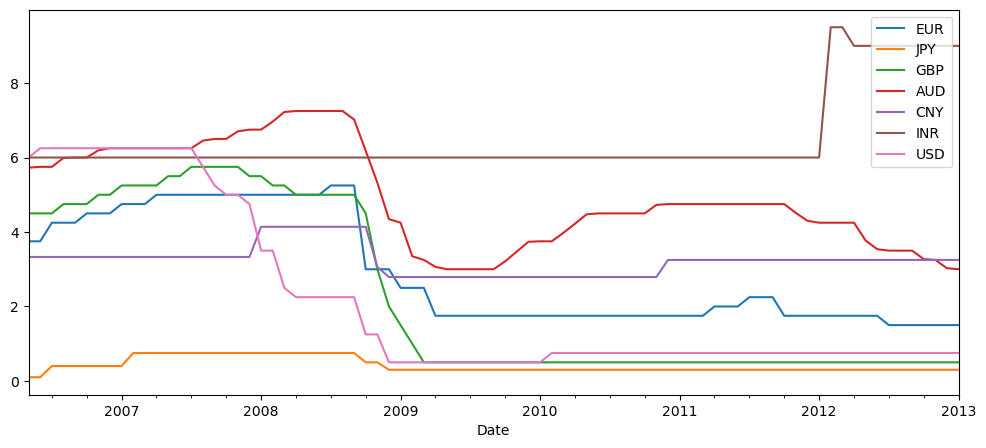

In [23]:
# tomar hastra el minimo máximo de datos cargados (ver tabla 1)
finalInt_df.loc[:"2013-01-01"].plot(figsize=(12,5))

### Descuento a plazo D(t, T)

Recordemos que el descuento a plazo se define como

$$
D(t, T) \approx r_f - r_d
$$

Donde $r_f$ es la tasa de interés de la moneda extrangera y $r_d$ es la tasa de interés de la la moneda doméstica.

In [24]:
# En este caso el dolar (USD) será la moneda doméstica. Tomamos solo las monedas extrangeras.
foreing_df = finalInt_df.iloc[:, :-1]
domestic_df = finalInt_df.iloc[:, -1]

In [25]:
foreing_df.head()

,EUR,JPY,GBP,AUD,CNY,INR
Date,,,,,,
2006-05-01,3.75,0.1,4.50,5.728261,3.33,6.0
2006-06-01,3.75,0.1,4.50,5.750000,3.33,6.0
2006-07-01,4.25,0.4,4.50,5.750000,3.33,6.0
2006-08-01,4.25,0.4,4.75,5.989130,3.33,6.0
2006-09-01,4.25,0.4,4.75,6.000000,3.33,6.0


In [26]:
domestic_df

Date
2006-05-01    6.00
2006-06-01    6.25
2006-07-01    6.25
2006-08-01    6.25
2006-09-01    6.25
              ... 
2012-10-01    0.75
2012-11-01    0.75
2012-12-01    0.75
2013-01-01    0.75
2013-02-01    0.75
Freq: MS, Name: USD, Length: 82, dtype: float64

In [27]:
des_plazo = pd.DataFrame(foreing_df.values - domestic_df.values.reshape(domestic_df.shape[0],1),
                        index=foreing_df.index, columns=foreing_df.columns)

In [28]:
des_plazo.head()

,EUR,JPY,GBP,AUD,CNY,INR
Date,,,,,,
2006-05-01,-2.25,-5.90,-1.50,-0.271739,-2.67,0.00
2006-06-01,-2.50,-6.15,-1.75,-0.500000,-2.92,-0.25
2006-07-01,-2.00,-5.85,-1.75,-0.500000,-2.92,-0.25
2006-08-01,-2.00,-5.85,-1.50,-0.260870,-2.92,-0.25
2006-09-01,-2.00,-5.85,-1.50,-0.250000,-2.92,-0.25


In [29]:
def signalCarry(df):
    """
    D > 0: Comprar (1)
    D < 0: Vender (-1)
    """
    signal = np.where(df > 0, 1, 0)
    signal = np.where(df < 0, -1, signal)
    
    return pd.DataFrame(signal, index=df.index, columns=df.columns)

In [30]:
signal_carry = signalCarry(des_plazo)
col = signal_carry.columns.to_list()
col.sort()
signal_carry = signal_carry[col]

In [31]:
signal_carry

,AUD,CNY,EUR,GBP,INR,JPY
Date,,,,,,
2006-05-01,-1,-1,-1,-1,0,-1
2006-06-01,-1,-1,-1,-1,-1,-1
2006-07-01,-1,-1,-1,-1,-1,-1
2006-08-01,-1,-1,-1,-1,-1,-1
2006-09-01,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...
2012-10-01,1,1,1,-1,1,-1
2012-11-01,1,1,1,-1,1,-1
2012-12-01,1,1,1,-1,1,-1


### Retornos de la estrategia

Se calculan de la misma manera que con la estrategia de Momentum.

\begin{equation}
    R_p = \sum_{1=1}^{N} s_i w_i R_i
\end{equation}


In [32]:
portfolioCarry = signal_carry * returns_df
portfolioCarry_ret = portfolioCarry.sum(axis=1)

In [33]:
portfolioCarry_ret

Date
2006-05-01    0.000000
2006-06-01    0.008860
2006-07-01   -0.051562
2006-08-01   -0.042250
2006-09-01    0.064381
                ...   
2012-10-01    0.006490
2012-11-01   -0.007293
2012-12-01   -0.038962
2013-01-01   -0.036885
2013-02-01    0.000000
Freq: MS, Length: 82, dtype: float64

---
## Estrategia: Combo de momentum & carry

Para ejecutar la estrategia de combo de Momentum y Carry juntaremos en un único dataframe los retornos de ambos portafolios (momentum y carry).

In [34]:
combo_df = pd.concat([portafolioMom_df, portfolioCarry_ret], axis=1)
combo_df.dropna(inplace=True)
combo_df.columns = ["Momentum", "Carry"]

In [35]:
combo_df

,Momentum,Carry
Date,,
2008-01-01,-0.079266,0.077775
2008-02-01,-0.042107,0.086894
2008-03-01,-0.090775,0.042192
2008-04-01,0.035551,-0.006011
2008-05-01,-0.034424,0.025405
...,...,...
2012-09-01,0.036658,-0.041420
2012-10-01,0.007798,0.006490
2012-11-01,0.015897,-0.007293


### Desviaciones estándar

In [36]:
std_ = combo_df.std()
std_

Momentum    0.071328
Carry       0.075378
dtype: float64

### Ponderaciones

In [37]:
combo_df.corr()

,Momentum,Carry
Momentum,1.000000,0.044201
Carry,0.044201,1.000000


In [38]:
corr = combo_df.corr().iloc[0,1]

In [39]:
w1 = (std_[1]**2 - std_[0]*std_[1]*corr) / (std_[0]**2 + std_[1]**2 - 2*std_[0]*std_[1]*corr)
w2 = (std_[0]**2 - std_[0]*std_[1]*corr) / (std_[0]**2 + std_[1]**2 - 2*std_[0]*std_[1]*corr)

In [40]:
w1

0.5288546036088082

In [41]:
w2

0.4711453963911918

In [42]:
print(f" Ponderación para cada Estrategia \n --------------------------------\n")
print(f" w1 = {w1:.2f} \n w2 = {w2:.2f}")

 Ponderación para cada Estrategia 
 --------------------------------

 w1 = 0.53 
 w2 = 0.47


In [43]:
%load_ext version_information
%version_information pandas, numpy, scipy, matplotlib, yfinance

Software versions
Python 3.11.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.15.0
OS Windows 10 10.0.22621 SP0
pandas 2.0.3
numpy 1.24.3
scipy 1.11.1
matplotlib 3.7.2
yfinance 0.2.31
Mon Oct 23 12:23:50 2023 Hora est. Pacífico, Sudamérica